In [11]:
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.metrics import *
import sklearn
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
warnings.simplefilter("ignore")
import os
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import neighbors

#EDA

In [2]:
data = pd.read_csv('/content/drive/MyDrive/Data/Mini_Proj/diabetes.csv')
data.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [3]:
data.shape

(768, 9)

In [4]:
data.groupby('Outcome').Pregnancies.count()

Outcome
0    500
1    268
Name: Pregnancies, dtype: int64

In [5]:
data.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
train, test = train_test_split(data, test_size = 0.2, random_state = 1)

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

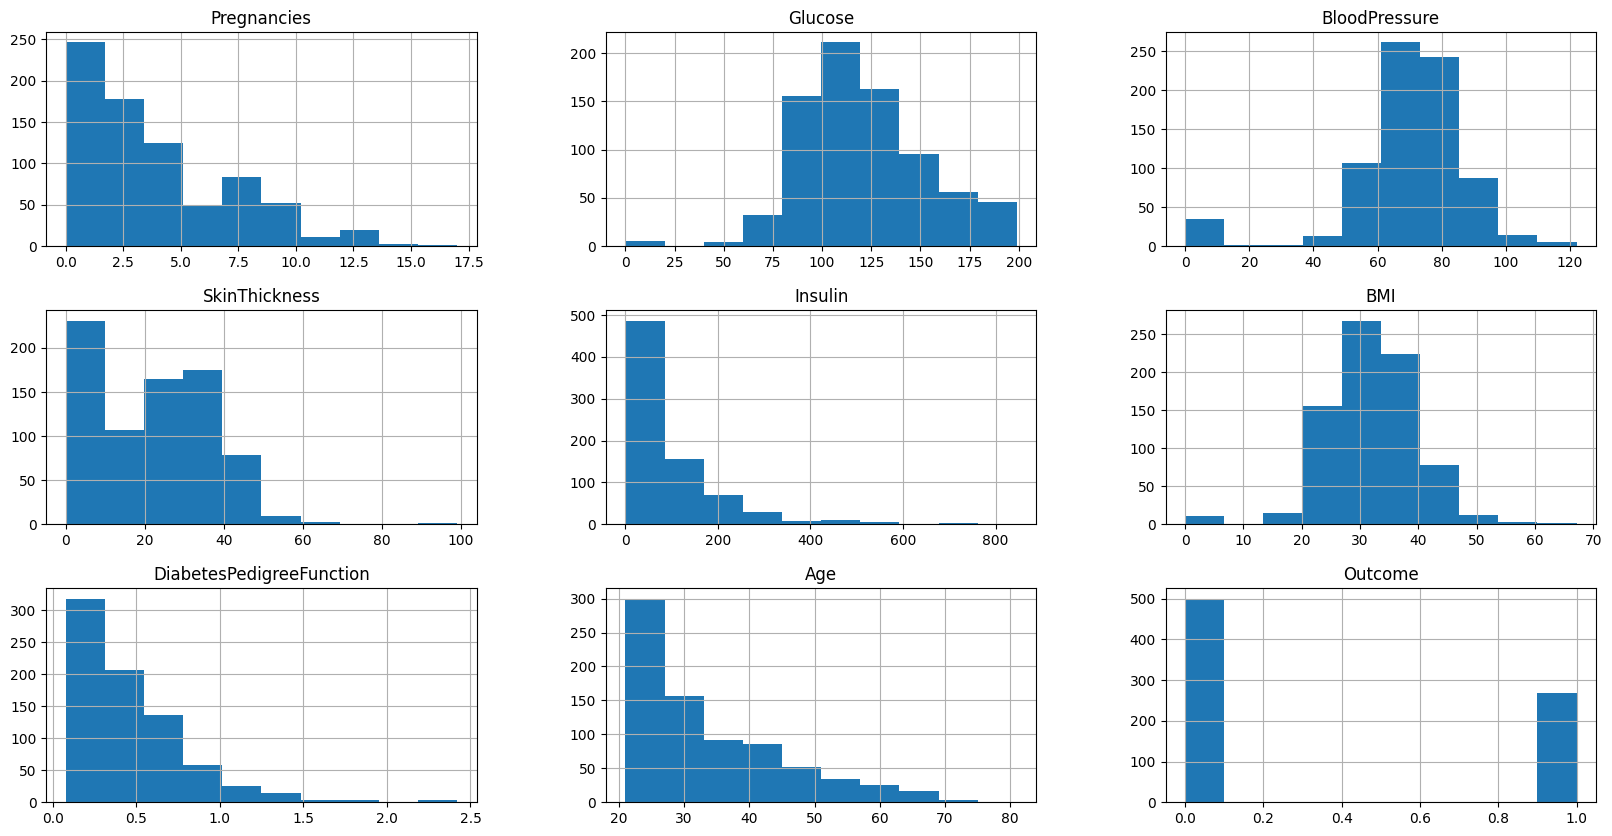

In [7]:
data.hist(figsize = (20, 10))

<Axes: >

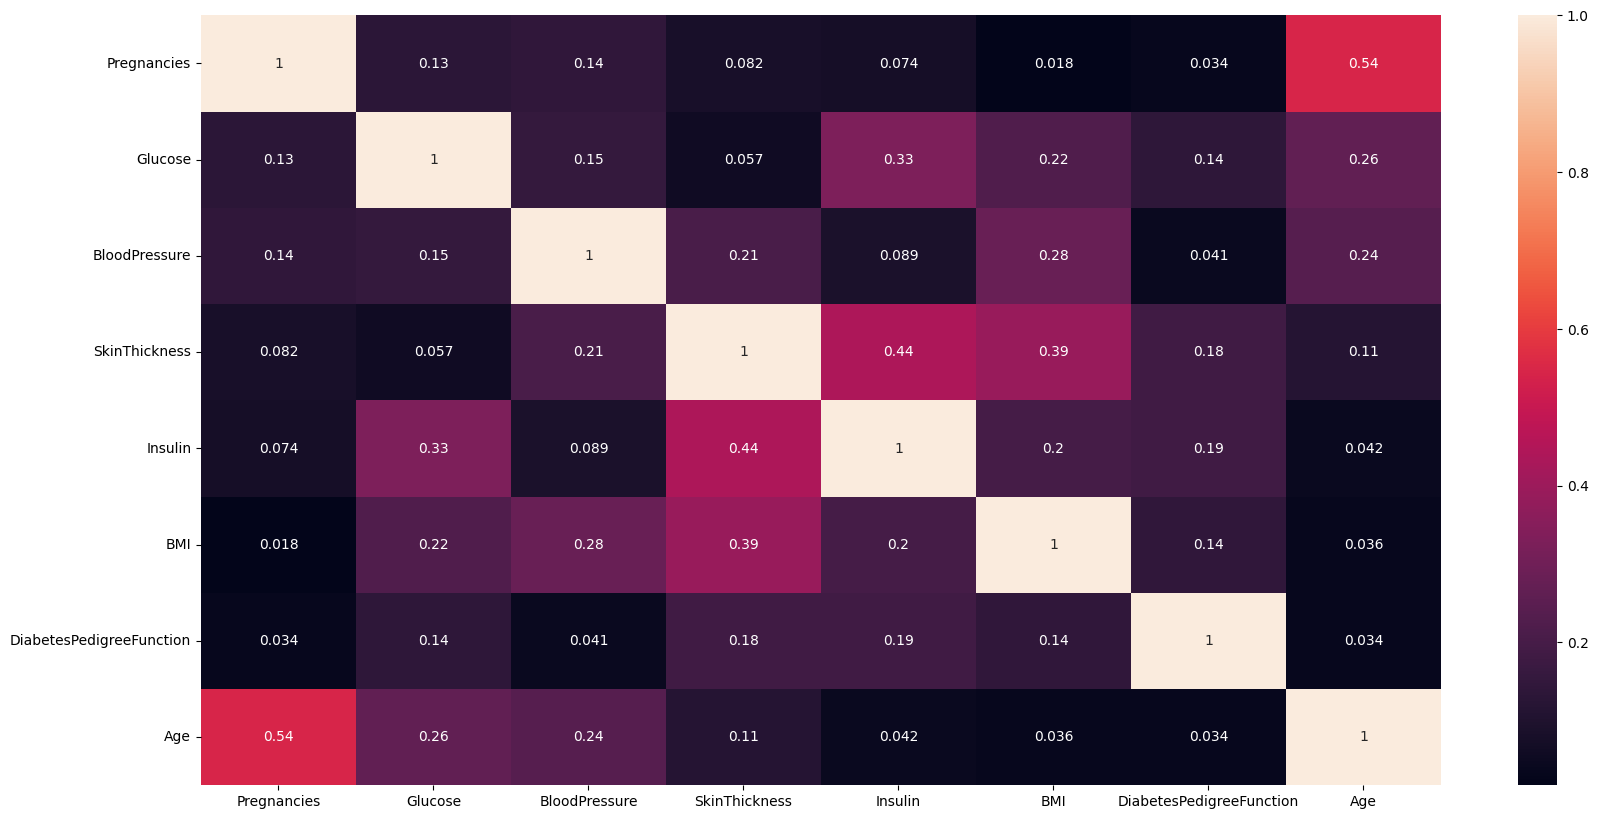

In [8]:
cor = data.drop('Outcome', axis = 1).corr().abs()
plt.subplots(figsize=(20, 10))
sns.heatmap(cor, annot = True)

In [14]:
clf = neighbors.KNeighborsClassifier(n_neighbors = 11, p = 2)
clf.fit(train.drop('Outcome', axis = 1), train.Outcome)
y_pred = clf.predict(test.drop('Outcome', axis = 1))
print(classification_report(test.Outcome, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81        99
           1       0.66      0.60      0.63        55

    accuracy                           0.75       154
   macro avg       0.72      0.71      0.72       154
weighted avg       0.74      0.75      0.74       154



#Binning

In [10]:
bins = [18, 25, 35, 45, 60, 80]
names = ['18 - 25', '25 - 35', '35 - 45', '45 - 60', '60 - 80']
data['Age Range'] = pd.cut(data['Age'], bins, labels = names, include_lowest = True)
le = LabelEncoder()
data['Age Range'] = le.fit_transform(data['Age Range']) 
data['Age Range']

0      3
1      1
2      1
3      0
4      1
      ..
763    4
764    1
765    1
766    3
767    0
Name: Age Range, Length: 768, dtype: int64

#Build graph

The graph data is represented by the graph_info tuple, which consists of the following three elements:

1. node_features: This is a [num_nodes, num_features] NumPy array that includes the node features. In this dataset, the nodes are the papers, and the node_features are the word-presence binary vectors of each paper.
2. edges: This is [num_edges, num_edges] NumPy array representing a sparse adjacency matrix of the links between the nodes. In this example, the links are the citations between the papers.
3. edge_weights (optional): This is a [num_edges] NumPy array that includes the edge weights, which quantify the relationships between nodes in the graph. In this example, there are no weights for the paper citations.

In [ ]:
feature_names = set(train.drop('Outcome', axis = 1).columns)
num_features = len(feature_names)
num_classes = train.Outcome.nunique()

hidden_units = [64, 32]
learning_rate = 0.01
dropout_rate = 0.1
num_epochs = 300
batch_size = 256

In [ ]:
data.reset_index(inplace = True)

In [ ]:
train, test = train_test_split(data, test_size = 0.2, random_state = 1)

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []
    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

1. Prepare: The input node representations are processed using a FFN to produce a message. You can simplify the processing by only applying linear transformation to the representations.
2. Aggregate: The messages of the neighbours of each node are aggregated with respect to the edge_weights using a permutation invariant pooling operation, such as sum, mean, and max, to prepare a single aggregated message for each node. See, for example, tf.math.unsorted_segment_sum APIs used to aggregate neighbour messages.
3. Update: The node_repesentations and aggregated_messages—both of shape [num_nodes, representation_dim]— are combined and processed to produce the new state of the node representations (node embeddings). If combination_type is gru, the node_repesentations and aggregated_messages are stacked to create a sequence, then processed by a GRU layer. Otherwise, the node_repesentations and aggregated_messages are added or concatenated, then processed using a FFN.

In [ ]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="attention",
        combination_type="gated",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = layers.GRU(
                units=hidden_units[-1],
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_sequences=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)
        self.dense_q = tf.keras.layers.Dense(units=hidden_units[-1], activation=tf.keras.layers.LeakyReLU(alpha=0.01))
        self.dense_v = tf.keras.layers.Dense(units=hidden_units[-1], activation=tf.keras.layers.LeakyReLU(alpha=0.01))

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "attention":  
          
          queries = self.dense_q(node_repesentations)
          value = self.dense_v(neighbour_messages)

          aggregated_message = tf.keras.layers.Attention(
              dropout=0.1
          )([queries, value])

        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")
        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="mean",
        combination_type="gru",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes,activation = 'softmax', name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

In [ ]:
import pandas as pd
from itertools import combinations

def create_group(feature, df, id):
  #df: Dataframe; feature: truong dung de group by

  # Groupby 'class_id' và tạo dataframe mới từ cặp chỉ số
  grouped = df.groupby(feature)[id].apply(list)

  # Tạo set để theo dõi các cặp chỉ số đã xuất hiện
  seen_pairs = set()

  # Tạo dataframe mới từ danh sách các cặp chỉ số và áp dụng điều kiện
  df_new = pd.DataFrame(columns=['index source', 'index target'])
  for indices in grouped.values:
      pairs = list(combinations(indices, 2))
      for pair in pairs:
          index_source, index_target = pair
          if index_source != index_target:
              sorted_pair = tuple(sorted(pair))
              if sorted_pair not in seen_pairs:
                  seen_pairs.add(sorted_pair)
                  df_new = df_new.append({'index source': index_source, 'index target': index_target}, ignore_index=True)

  # Hiển thị dataframe mới
  return df_new

df_new = create_group('Outcome', train, 'index')
df_new.to_csv('egde_user_user2.csv', index = False)

In [ ]:
def create_graph_info(df_edge, df_feature):
  # Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
  edges = df_edge[['index source', 'index target']].to_numpy().T
  # Create an edge weights array of ones.
  edge_weights = tf.ones(shape=edges.shape[1])
  # Create a node features array of shape [num_nodes, num_features].
  node_features = tf.cast(
      df_feature[feature_names].to_numpy(), dtype=tf.dtypes.float32
  )
  # Create graph info tuple with node_features, edges, and edge_weights.
  graph_info = (node_features, np.asarray(edges).astype('int32'), edge_weights)

  print("Edges shape:", edges.shape)
  print("Nodes shape:", node_features.shape)
  return graph_info

In [ ]:
neg, pos = np.bincount(train['Outcome'])
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.7655860349127181, 1: 1.4413145539906103}

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
        class_weight=class_weight
    )

    return history

##Graph Strategy 1: User - User

In [ ]:
graph_info = create_graph_info(df_new, data)

gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    aggregation_type="mean",
    combination_type="gru",
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

Edges shape: (2, 102778)
Nodes shape: (768, 8)
GNN output shape: tf.Tensor(
[[9.9995840e-01 4.1661573e-05]
 [9.9997818e-01 2.1778827e-05]
 [9.9999774e-01 2.2859651e-06]], shape=(3, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (768, 32)                 2944      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 10912     
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 10912     
 )                                                               
                                                                 
 postprocess (Sequential)    (768, 32)                 4576      
                                                       

In [ ]:
x_train = train.index.to_numpy()
history = run_experiment(gnn_model, x_train, train.Outcome)

Epoch 1/300
3/3 [==============================] - 14s 507ms/step - loss: 0.9230 - acc: 0.4971 - val_loss: 1.5721 - val_acc: 0.3871
Epoch 2/300
3/3 [==============================] - 0s 70ms/step - loss: 0.6533 - acc: 0.6737 - val_loss: 1.3117 - val_acc: 0.3871
Epoch 3/300
3/3 [==============================] - 0s 62ms/step - loss: 0.6127 - acc: 0.6737 - val_loss: 1.3844 - val_acc: 0.3871
Epoch 4/300
3/3 [==============================] - 0s 61ms/step - loss: 0.6261 - acc: 0.6603 - val_loss: 1.6612 - val_acc: 0.3871
Epoch 5/300
3/3 [==============================] - 0s 59ms/step - loss: 0.6167 - acc: 0.6948 - val_loss: 1.9417 - val_acc: 0.3871
Epoch 6/300
3/3 [==============================] - 0s 61ms/step - loss: 0.5783 - acc: 0.7313 - val_loss: 1.5603 - val_acc: 0.3871
Epoch 7/300
3/3 [==============================] - 0s 60ms/step - loss: 0.5539 - acc: 0.7582 - val_loss: 1.5197 - val_acc: 0.3871
Epoch 8/300
3/3 [==============================] - 0s 58ms/step - loss: 0.5499 - acc: 0.

In [ ]:
y_pred = gnn_model.predict(test.index.to_numpy())
print(classification_report(np.argmax(y_pred, axis = 1), test.Outcome))

5/5 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.72      0.90      0.80        79
           1       0.85      0.63      0.72        75

    accuracy                           0.77       154
   macro avg       0.79      0.76      0.76       154
weighted avg       0.78      0.77      0.76       154



## Graph Strategy 2: User - User - Symptomp

In [ ]:
from itertools import product

# Tạo dataframe mới từ danh sách các cặp chỉ số
df_new2 = create_group(['Age Range', 'Outcome'], train, 'index')

graph_info_new = create_graph_info(df_new2, data)

gnn_model_2 = GNNNodeClassifier(
    graph_info=graph_info_new,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    aggregation_type="sum",
    combination_type="concat",
    name="gnn_model",
)

print("GNN output shape:", gnn_model_2([1, 10, 100]))

Edges shape: (2, 30244)
Nodes shape: (768, 8)
GNN output shape: tf.Tensor(
[[5.06992448e-10 1.00000000e+00]
 [1.40848696e-11 1.00000000e+00]
 [4.81358524e-14 1.00000000e+00]], shape=(3, 2), dtype=float32)


In [ ]:
x_train = train.index.to_numpy()
history = run_experiment(gnn_model_2, x_train, train.Outcome)

Epoch 1/300
3/3 [==============================] - 12s 306ms/step - loss: 0.8007 - acc: 0.5470 - val_loss: 2.5502 - val_acc: 0.3871
Epoch 2/300
3/3 [==============================] - 0s 33ms/step - loss: 0.6269 - acc: 0.7044 - val_loss: 1.4440 - val_acc: 0.3871
Epoch 3/300
3/3 [==============================] - 0s 42ms/step - loss: 0.5375 - acc: 0.7370 - val_loss: 0.9453 - val_acc: 0.5591
Epoch 4/300
3/3 [==============================] - 0s 39ms/step - loss: 0.5642 - acc: 0.7198 - val_loss: 0.8951 - val_acc: 0.3441
Epoch 5/300
3/3 [==============================] - 0s 34ms/step - loss: 0.5335 - acc: 0.7332 - val_loss: 1.0404 - val_acc: 0.3763
Epoch 6/300
3/3 [==============================] - 0s 31ms/step - loss: 0.4692 - acc: 0.7505 - val_loss: 1.0283 - val_acc: 0.3871
Epoch 7/300
3/3 [==============================] - 0s 33ms/step - loss: 0.4294 - acc: 0.8081 - val_loss: 0.9913 - val_acc: 0.3978
Epoch 8/300
3/3 [==============================] - 0s 31ms/step - loss: 0.3744 - acc: 0.

In [ ]:
y_pred = gnn_model_2.predict(test.index.to_numpy())
print(classification_report(np.argmax(y_pred, axis = 1), test.Outcome))

5/5 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       121
           1       0.40      0.67      0.50        33

    accuracy                           0.71       154
   macro avg       0.64      0.70      0.65       154
weighted avg       0.78      0.71      0.74       154



#Strategy 3: Xây dựng đồ thị dựa trên độ tương đồng giữa 2 người

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

df_test = train.drop(['Outcome', 'Age Range'], axis = 1).copy()
cosine_sim = cosine_similarity(df_test)

# Tạo DataFrame mới với cặp index thỏa điều kiện
indices = train['index'].tolist()
pairs = []
for i in range(len(cosine_sim)):
    for j in range(i + 1, len(cosine_sim[i])):
        if cosine_sim[i, j] >= 0.8:
            pairs.append((indices[i], indices[j]))

df_pairs = pd.DataFrame(pairs, columns=['index source', 'index target'])
# sampled_df = df_pairs.sample(frac=0.5, random_state=42)

In [ ]:
graph_info_new = create_graph_info(df_pairs, data)

gnn_model_3 = GNNNodeClassifier(
    graph_info=graph_info_new,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    aggregation_type="attention",
    combination_type="concat",
    name="gnn_model",
)

print("GNN output shape:", gnn_model_3([1, 10, 100]))

Edges shape: (2, 130489)
Nodes shape: (768, 8)
GNN output shape: tf.Tensor(
[[2.5683400e-04 9.9974316e-01]
 [3.5541572e-05 9.9996448e-01]
 [1.2411634e-02 9.8758835e-01]], shape=(3, 2), dtype=float32)


In [ ]:
x_train = train.index.to_numpy()
history = run_experiment(gnn_model_3, x_train, train.Outcome)

Epoch 1/300
3/3 [==============================] - 13s 492ms/step - loss: 0.8111 - acc: 0.5048 - val_loss: 1.9372 - val_acc: 0.3871
Epoch 2/300
3/3 [==============================] - 1s 208ms/step - loss: 0.6123 - acc: 0.7006 - val_loss: 0.7942 - val_acc: 0.4731
Epoch 3/300
3/3 [==============================] - 1s 194ms/step - loss: 0.5993 - acc: 0.7140 - val_loss: 1.0052 - val_acc: 0.3871
Epoch 4/300
3/3 [==============================] - 1s 193ms/step - loss: 0.5522 - acc: 0.7217 - val_loss: 2.2112 - val_acc: 0.3871
Epoch 5/300
3/3 [==============================] - 1s 194ms/step - loss: 0.5280 - acc: 0.7562 - val_loss: 3.1158 - val_acc: 0.3871
Epoch 6/300
3/3 [==============================] - 1s 198ms/step - loss: 0.5650 - acc: 0.7313 - val_loss: 2.7994 - val_acc: 0.3871
Epoch 7/300
3/3 [==============================] - 1s 206ms/step - loss: 0.5628 - acc: 0.6814 - val_loss: 2.4071 - val_acc: 0.3871
Epoch 8/300
3/3 [==============================] - 1s 196ms/step - loss: 0.5637 - 

In [ ]:
y_pred = gnn_model_3.predict(test.index.to_numpy())
print(classification_report(np.argmax(y_pred, axis = 1), test.Outcome))

5/5 [==============================] - 1s 43ms/step
              precision    recall  f1-score   support

           0       0.73      0.90      0.80        80
           1       0.85      0.64      0.73        74

    accuracy                           0.77       154
   macro avg       0.79      0.77      0.77       154
weighted avg       0.79      0.77      0.77       154

